# Le Mécanisme Exponentiel appliqué au quantile

## Installation des packages nécessaires

In [ ]:
%pip install 'opendp[polars]'

## Les données suivant une distribution normale

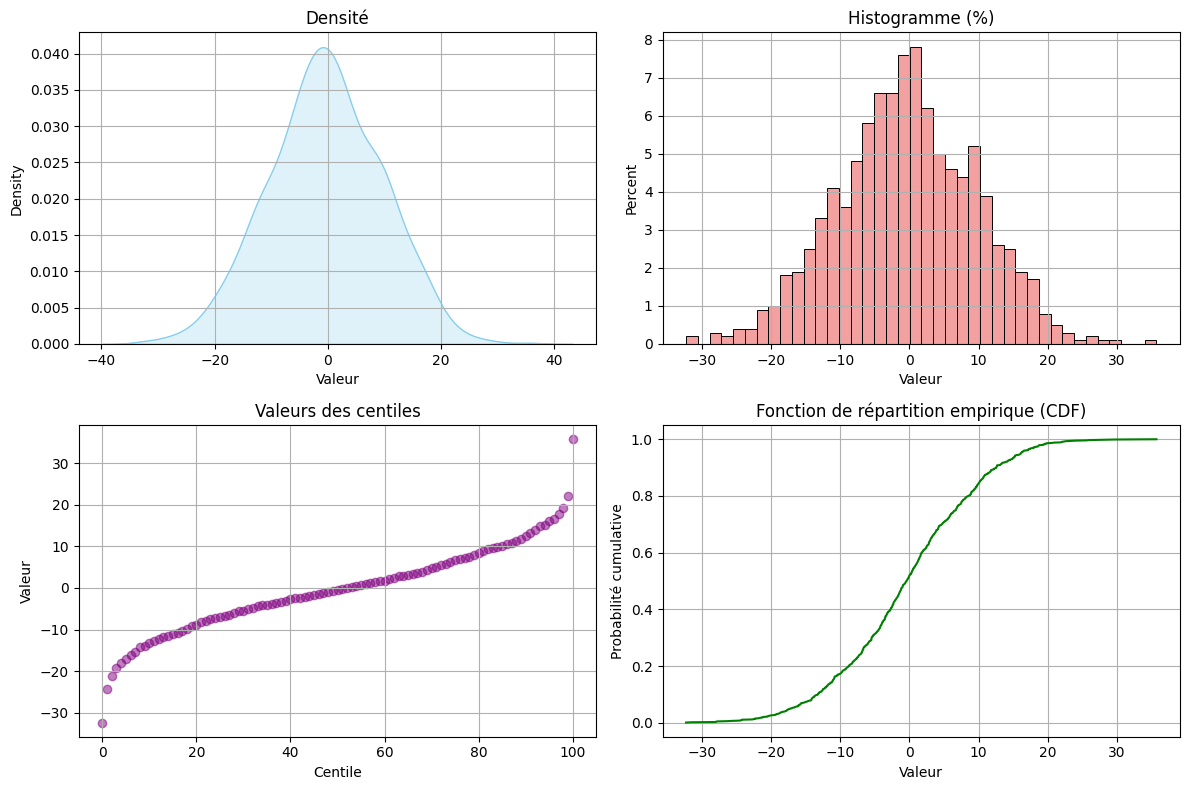

data
count  1000.000000
mean     -0.395641
std      10.012883
min     -32.310550
25%      -6.845566
50%      -0.411856
75%       6.688657
max      35.715792

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(123) 

data = np.random.normal(scale=10, size=1000)
sorted_data = np.sort(data)
cdf = np.arange(1, len(data) + 1) / len(data)

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 lignes, 2 colonnes

# Graphique en haut à gauche
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data, fill=True, color='skyblue', ax=ax1)
ax1.set_title("Densité")
ax1.set_xlabel("Valeur")
ax1.grid(True)

# Graphique en haut à droite
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data, stat="percent", bins=40, color='lightcoral', ax=ax2)
ax2.set_title("Histogramme (%)")
ax2.set_xlabel("Valeur")
ax2.grid(True)

# Graphique en bas sur toute la largeur
ax3 = fig.add_subplot(gs[1, 0])

# Calcul des centiles (0 à 100)
centiles = np.arange(101)
valeurs = np.percentile(data, centiles)

ax3.scatter(centiles, valeurs, color="purple", alpha=0.5)
ax3.set_title("Valeurs des centiles")
ax3.set_xlabel("Centile")
ax3.set_ylabel("Valeur")
ax3.grid(True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(sorted_data, cdf, color="green")
ax4.set_title("Fonction de répartition empirique (CDF)")
ax4.set_xlabel("Valeur")
ax4.set_ylabel("Probabilité cumulative")
ax4.grid(True)

plt.tight_layout()
plt.show()

df = pd.DataFrame({"data": data})
df.describe()

## Chaîne représentant le processus de 3 façons différentes

In [ ]:
import opendp.prelude as dp
import numpy as np
import polars as pl

dp.enable_features("contrib", "honest-but-curious")

np.random.seed(123)  # N'affecte pas l'aléa d'OpenDP

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()

data = np.random.normal(scale=10, size=1000)
candidats = np.linspace(-50, 50, 101).tolist()
alpha = 0.7
scale = 1

# Méthode 1 (base)

quantile = space >> dp.m.then_private_quantile(
    candidates=candidats,
    alpha=alpha,
    scale=scale
)

sensibilite = quantile.map(d_in=1)

# Méthode 2 (déstructuré)

quantile = (
    space
    # 1. transformation: calcul du score associé à chaque candidat
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    # 2. measurement: tire l'index score le plus petit après ajout du bruit
    >> dp.m.then_report_noisy_max_gumbel(scale=scale, optimize="min")
    # 3. postprocessor: renvoie le candidat à partir de l'index
    >> (lambda i: candidats[i])
)

# Méthode 3 (polars)

df = pl.DataFrame({
    "valeurs": data
})

context = dp.Context.compositor(
    data=df.lazy(),
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=0.1),
    split_evenly_over=1,
    margins=[
        dp.polars.Margin(
            max_partition_length=1000
        ),
    ],
) 

query_quantile = (
    context.query()
    .select(
        pl.col.valeurs
        .fill_null(0)
        .dp.quantile(0.75, candidats)
    )
)  

query_quantile.release().collect().item()

print(f"La valeur du quantile d'ordre {alpha} respectant la DP est", quantile(data))
print(f"La senbsibilité de tout le processus est", quantile.map(d_in=1))

## La fonction de score

$\textrm{score}(x, c, \alpha_{num}, \alpha_{den}) = -|\alpha_{den} \cdot \#(x < c) - \alpha_{num} \cdot (|x| - \#(x = c))|$

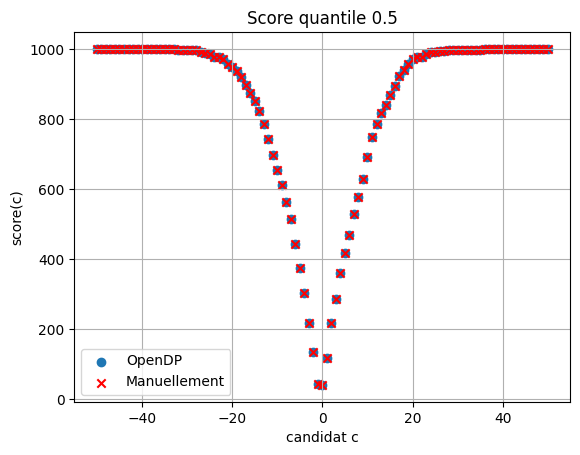

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import opendp.prelude as dp

dp.enable_features("contrib")

np.random.seed(123)
data = np.random.normal(scale=10, size=1000)
candidats = np.linspace(-50, 50, 101)
alpha = 0.5

quantile_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidats, 
    alpha=alpha)

scores = quantile_scores(data)

def manual_quantile_score(data, candidats, alpha, et_si=False):
    if alpha == 0:
        alpha_num, alpha_denum = 0, 1
    elif alpha == 0.25:
        alpha_num, alpha_denum = 1, 4
    elif alpha == 0.5:
        alpha_num, alpha_denum = 1, 2
    elif alpha == 0.75:
        alpha_num, alpha_denum = 3, 4
    elif alpha == 1:
        alpha_num, alpha_denum = 1, 1
    else:
        alpha_num = int(np.floor(alpha * 10_000))
        alpha_denum = 10_000

    if et_si == True:
        alpha_num = int(np.floor(alpha * 10_000))
        alpha_denum = 10_000

    scores = []
    for c in candidats:
        n_less = np.sum(data < c)
        n_equal = np.sum(data == c)
        score = alpha_denum * n_less - alpha_num * (len(data) - n_equal)
        scores.append(abs(score))

    return np.array(scores), max(alpha_num, alpha_denum - alpha_num)

scores_m, _ = manual_quantile_score(data, candidats, alpha)

plt.scatter(candidats, scores, marker='o', label="OpenDP")
plt.scatter(candidats, scores_m, color = "red", marker='x', label="Manuellement")
plt.title(f"Score quantile {alpha}")
plt.xlabel("candidat c")
plt.ylabel("score(c)")
plt.legend()
plt.grid(True)
plt.show()


## Comparaison résultat si score multiplié par alpha_denom = 10_000

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
alpha = 0.75
list_sensibilite = [3, 7500]
epsilon = 0.1

fig, axs = plt.subplots(2, figsize=(12, 10))

for i, ax in enumerate(axs.flat):

    scores, _ = manual_quantile_score(data, candidats, alpha=alpha, et_si=[False, True][i])
        
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * list_sensibilite[i] / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {alpha}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non chevauchement', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

## Intervalle de confiance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
list_alpha = [0, 0.2, 0.5, 0.75]
epsilon = 0.1

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non chevauchement', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
import matplotlib.animation as animation
from IPython.display import HTML

# Paramètres
np.random.seed(123)
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
epsilon = 0.1

# Préparation de la figure
fig, ax = plt.subplots(figsize=(12, 6))

# Animation
def animate(i):
    ax.clear()
    alpha = (i) / 100  # variation de 0.01 à 0.99

    scores, sensi = manual_quantile_score(data, candidats, alpha=alpha, et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    count = 0
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
            count += 1
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {alpha}, epsilon = {epsilon}, nb_candidats_potentiels = {count}")
    ax.set_ylim(-1e6,1.2e7)
    ax.grid(True)
    ax.set_xlabel("Valeur candidate")
    ax.set_ylabel("Score quantile")
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non chevauchement', markerfacecolor='blue', markersize=8)
    ])
    return ax.collections + ax.lines

# Création et affichage de l'animation dans le notebook
anim = animation.FuncAnimation(fig, animate, frames=100,  blit=False, interval=100)
plt.close(fig)
HTML(anim.to_jshtml())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
list_alpha = [0.5]  # Tu peux en ajouter d'autres si tu veux
epsilon = 0.1

fig, axs = plt.subplots(len(list_alpha), 2, figsize=(14, 5 * len(list_alpha)))

if len(list_alpha) == 1:
    axs = np.array([axs])  # for uniform indexing if single row

for i, alpha in enumerate(list_alpha):
    ax_left, ax_right = axs[i]

    # Score quantile manuel
    scores, sensi = manual_quantile_score(data, candidats, alpha=alpha, et_si=True)

    # Calcul des probabilités renormalisées
    proba_non_norm = np.exp(- epsilon * scores / (2 * sensi))
    proba = proba_non_norm / np.sum(proba_non_norm)

    # Calcul des intervalles de confiance autour des scores
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)
    lower = scores + low_q
    upper = scores + high_q
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Couleurs : rouge si chevauche l’intervalle du minimum
    colors = ['red' if not (u < min_lower or l > min_upper) else 'blue'
              for l, u in zip(lower, upper)]

    # ➤ Graphe gauche : scores + barres d’erreur
    ax_left.scatter(candidats, scores, c=colors, label='Scores')
    ax_left.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                     fmt='none', capsize=2, color='black', alpha=0.5)
    ax_left.set_title(rf"Scores, $\alpha$={alpha}, n={n}, $\varepsilon$={epsilon}")
    ax_left.grid(True)
    ax_left.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Hors chevauchement', markerfacecolor='blue', markersize=8)
    ])

    # ➤ Graphe droite : scatter proba
    ax_right.scatter(candidats, proba, color="green")
    ax_right.set_title(rf"Distribution des proba, $\alpha$={alpha}")
    ax_right.set_ylabel("Probabilité")
    ax_right.set_xlabel("Candidat")
    ax_right.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
import matplotlib.animation as animation
from IPython.display import HTML

# Paramètres
np.random.seed(123)
n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-35, 35, 71).tolist()
epsilon = 0.1

# Figure 1x2
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(14, 6))

def animate(i):
    ax_left.clear()
    ax_right.clear()

    alpha = i / 100  # varie de 0.00 à 0.99

    # --- Calculs principaux ---
    scores, sensi = manual_quantile_score(data, candidats, alpha=alpha, et_si=True)
    proba_non_norm = np.exp(- epsilon * scores / (2 * sensi))
    proba = proba_non_norm / np.sum(proba_non_norm)

    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)
    lower = scores + low_q
    upper = scores + high_q

    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Couleurs selon chevauchement
    colors = []
    count = 0
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')
            count += 1
        else:
            colors.append('blue')

    # --- Graphe gauche ---
    ax_left.scatter(candidats, scores, c=colors)
    ax_left.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                     fmt='none', capsize=2, color='black', alpha=0.5)
    ax_left.set_title(rf"Score, $\alpha$={alpha:.2f}, nb_candidats={count}")
    ax_left.set_ylim(-1e6, 1.2e7)
    ax_left.set_xlabel("Valeur candidate")
    ax_left.set_ylabel("Score quantile")
    ax_left.grid(True)
    ax_left.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non chevauchement', markerfacecolor='blue', markersize=8)
    ])

    # --- Graphe droit ---
    ax_right.scatter(candidats, proba, color='green')
    ax_right.set_title("Proba du mécanisme exponentiel")
    ax_right.set_xlabel("Valeur candidate")
    ax_right.set_ylabel("Probabilité")
    ax_right.set_ylim(0, 1.1)
    ax_right.grid(True)

    return ax_left.collections + ax_left.lines + ax_right.collections + ax_right.lines

# Création animation
anim = animation.FuncAnimation(fig, animate, frames=100, blit=False, interval=100)
plt.close(fig)
HTML(anim.to_jshtml())


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import opendp.prelude as dp
dp.enable_features("contrib")
np.random.seed(123)

n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(0, 10, 11).tolist()
alpha = 0.7
epsilon = 0.1

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()

scale = dp.binary_search_param(
    lambda s: space
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    >> dp.m.then_report_noisy_max_gumbel(scale=s, optimize="min")
    >> (lambda i: candidats[i]),
    d_in=1, d_out=epsilon)


# Ici tout va bien :)
quantile = (
    space
    # 1. transformation: calcul du score associé à chaque candidat
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    # 2. measurement: tire l'index score le plus petit après ajout du bruit
    >> dp.m.then_report_noisy_max_gumbel(scale=scale, optimize="min")
    # 3. postprocessor: renvoie le candidat à partir de l'index
    >> (lambda i: candidats[i])
)

# Simulation
N = 10000
list_values = [quantile(data) for _ in range(N)]

scores, sensi = manual_quantile_score(data, candidats, alpha=alpha, et_si=True)

proba_non_norm = np.exp(- epsilon * scores / (2 * sensi))
proba = proba_non_norm / np.sum(proba_non_norm)

counter = Counter(list_values)
counts = [counter.get(c, 0) for c in candidats]


# --- Probabilités empiriques ---
empiriques = np.array(counts) / sum(counts)

# --- Probabilités théoriques ---
theoriques = proba  # déjà normalisé

# --- Tracé côte à côte ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gauche : probas empiriques
ax1.scatter(candidats, empiriques, color="dodgerblue", label="Empirique", s=60)
ax1.set_title("Probabilités empiriques par simulation")
ax1.set_xlabel("Valeur candidate")
ax1.set_ylabel("Probabilité")
ax1.set_ylim(0, max(empiriques.max(), theoriques.max()) * 1.1)
ax1.grid(True)

# Droite : probas théoriques
ax2.scatter(candidats, theoriques, color="darkorange", label="Théorique", s=60)
ax2.set_title("Probabilités théoriques (mécanisme exponentiel)")
ax2.set_xlabel("Valeur candidate")
ax2.set_ylabel("Probabilité")
ax2.set_ylim(0, max(empiriques.max(), theoriques.max()) * 1.1)
ax2.grid(True)

plt.tight_layout()
plt.show()
print(proba)
print("-")
print(empiriques)

## Les résultats simulés

### Polars :D

### Pas polars :(

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r
import opendp.prelude as dp
from matplotlib.colors import LogNorm
from matplotlib import cm, colors as mcolors
dp.enable_features("contrib")
np.random.seed(123)

n = 1000
data = np.random.normal(scale=10, size=n)
candidats = np.linspace(-50, 50, 101).tolist()
alpha = 0.75
epsilon = 0.1

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()

scale = dp.binary_search_param(
    lambda s: space
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    >> dp.m.then_report_noisy_max_gumbel(scale=s, optimize="min")
    >> (lambda i: candidats[i]),
    d_in=1, d_out=epsilon)

# Avec ceci big trouble
quantile = space >> dp.m.then_private_quantile(
    candidates=candidats,
    alpha=alpha,
    scale=scale
)

# Ici tout va bien :)
quantile = (
    space
    # 1. transformation: calcul du score associé à chaque candidat
    >> dp.t.then_quantile_score_candidates(candidats, alpha=alpha)
    # 2. measurement: tire l'index score le plus petit après ajout du bruit
    >> dp.m.then_report_noisy_max_gumbel(scale=scale, optimize="min")
    # 3. postprocessor: renvoie le candidat à partir de l'index
    >> (lambda i: candidats[i])
)

# Simulation
N = 1000
list_values = [quantile(data) for _ in range(N)]

quantile_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidats, 
    alpha=alpha)

scores = quantile_scores(data)

# IC à 99 %
low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * quantile_scores.map(d_in=1) / epsilon)
lower = scores + low_q
upper = scores + high_q

counter = Counter(list_values)
counts = [counter.get(c, 0) for c in candidats]

norm = LogNorm(vmin=1, vmax=max(counts))  # attention : vmin > 0
cmap = cm.OrRd  # plus doux que Reds
colors = [mcolors.to_hex(cmap(norm(max(counter.get(c, 1), 1)))) for c in candidats]

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(candidats, scores, c=colors)
ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
            fmt='none', capsize=2, color='black', alpha=0.3)
ax.set_title("Scores avec IC 99% et candidats sélectionnés (rouge)")
ax.grid(True)

# Colorbar attachée explicitement à l'axe
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
plt.colorbar(sm, ax=ax, label="Fréquence")

plt.show()

print(f"{counter}")
print("Le nombre de candidats différent sélectionnés est :", len(set(list_values)))

# Etude cas non réel

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = np.linspace(0, 20, 100)

list_alpha = [0, 0.15, 0.3, 0.5]

valeurs = np.percentile(data, [100 * alpha for alpha in list_alpha])

print(valeurs)

# Définir les bornes de chaque intervalle d'1 unité
min_val = int(np.floor(data.min()))
max_val = int(np.ceil(data.max()))
bins = np.arange(min_val, max_val + 1, 1)  # pas de 1 unité

# Tracé
plt.figure(figsize=(10, 4))
sns.histplot(data, stat="percent", bins=bins, color='lightcoral', edgecolor='black')
plt.title("Histogramme (%) avec classes de largeur 1")
plt.xlabel("Valeur")
plt.ylabel("Pourcentage")
plt.grid(True)
plt.tight_layout()
plt.show()


## Cas n = 100

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 100
data = np.linspace(0, 20, n)
candidats = np.linspace(-20, 40, 61).tolist()
list_alpha = [0, 0.1, 0.25, 0.5]
epsilon = 1

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non chevauchement', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

## Cas n = 1000

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
n = 1000
data = np.linspace(0, 20, n)
candidats = np.linspace(0, 20, 21).tolist()
list_alpha = [0, 0.1, 0.25, 0.5]
epsilon = 0.1

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, n = {n}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non chevauchement', markerfacecolor='blue', markersize=8)
    ])
plt.tight_layout()
plt.show()

# Etude d'un cas particulier

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(123) 

data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
sorted_data = np.sort(data)
cdf = np.arange(1, len(data) + 1) / len(data)

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 lignes, 2 colonnes

# Graphique en haut à gauche
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data, fill=True, color='skyblue', ax=ax1)
ax1.set_title("Densité")
ax1.set_xlabel("Salaire")
ax1.grid(True)

# Graphique en haut à droite
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data, stat="percent", bins=40, color='lightcoral', ax=ax2)
ax2.set_title("Histogramme (%)")
ax2.set_xlabel("Salaire")
ax2.grid(True)

# Graphique en bas sur toute la largeur
ax3 = fig.add_subplot(gs[1, 0])

# Calcul des centiles (0 à 100)
centiles = np.arange(101)
valeurs = np.percentile(data, centiles)

candidats = np.linspace(0, 400, 101).tolist()
ax3.scatter(centiles, valeurs, color="purple", alpha=0.5)
ax3.set_title("Valeurs des centiles")
ax3.set_xlabel("Centile (0 → 100)")
ax3.set_ylabel("Valeur")
ax3.grid(True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(sorted_data, cdf, color="green")
ax4.set_title("Fonction de répartition empirique (CDF)")
ax4.set_xlabel("Valeur")
ax4.set_ylabel("Probabilité cumulative")
ax4.grid(True)

plt.tight_layout()
plt.show()

df = pd.DataFrame({"data": data})
df.describe()

## Focus sur la première moitié des données

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Données
np.random.seed(123)
data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
list_alpha = [0, 0.2, 0.4, 0.5]

valeurs = np.percentile(data, [100 * alpha for alpha in list_alpha])

print(valeurs)

data_filtre = data[data <= np.median(data)]

# Définir les bornes de chaque intervalle d'1 unité
min_val = int(np.floor(data_filtre.min()))
max_val = int(np.ceil(data_filtre.max()))
bins = np.arange(min_val, max_val + 1, 1)  # pas de 1 unité

# Tracé
plt.figure(figsize=(10, 4))
sns.histplot(data_filtre, stat="percent", bins=bins, color='lightcoral', edgecolor='black')
plt.title("Histogramme (%) avec classes de largeur 1")
plt.xlabel("Valeur")
plt.ylabel("Pourcentage")
plt.grid(True)
plt.tight_layout()
plt.show()


## Focus données intégrales

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Données
np.random.seed(123)
data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
list_alpha = [0, 0.8, 0.9, 0.99]

valeurs = np.percentile(data, [100 * alpha for alpha in list_alpha])

print(valeurs)

# Définir les bornes de chaque intervalle d'1 unité
min_val = int(np.floor(data.min()))
max_val = int(np.ceil(data.max()))
bins = np.arange(min_val, max_val + 1, 1)  # pas de 1 unité

# Tracé
plt.figure(figsize=(10, 4))
sns.histplot(data, stat="percent", bins=bins, color='lightcoral', edgecolor='black')
plt.title("Histogramme (%) avec classes de largeur 1")
plt.xlabel("Valeur")
plt.ylabel("Pourcentage")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

np.random.seed(123)
data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
candidats = np.linspace(-20, 200, 221).tolist()
list_alpha = [0, 0.8, 0.9, 0.99]
epsilon = 1

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

for i, ax in enumerate(axs.flat):

    scores, sensi = manual_quantile_score(data, candidats, alpha=list_alpha[i], et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {list_alpha[i]}, epsilon = {epsilon}")
    ax.grid(True)
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Chevauchement', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non chevauchement', markerfacecolor='blue', markersize=8)
    ])

plt.tight_layout()
plt.show()

Observations pour les min et max, s'il dépasse le vrai min ou le vrai max alors ils ont autant de chances d'êtres tirés que la vrai valeur donc il faut faire attention de ce coté la.

Si on ajoute des candidats qui étaient déjà pas compris dans la zone en rouge, pas de problème.

Il faut que la taille du dataset soit inversement proportionnelle à epsilon

Dans le cas de données uniformément réparties, multiplier n par 10 nécessite de diviser n par 10 pour retomber sur la meme courbe

Score max = taille dataset x 10 000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
import matplotlib.animation as animation
from IPython.display import HTML

# Paramètres
np.random.seed(123)
data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
candidats = np.linspace(-20, 200, 221).tolist()
epsilon = 1

# Préparation de la figure
fig, ax = plt.subplots(figsize=(12, 6))

# Animation
def animate(i):
    ax.clear()
    alpha = (i) / 100  # variation de 0.01 à 0.99

    scores, sensi = manual_quantile_score(data, candidats, alpha=alpha, et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    count = 0
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')  # intervalle touche celui du minimum
            count += 1
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha = 0.5)
    
    ax.set_title(rf"$\alpha$ = {alpha}, epsilon = {epsilon}, nb_candidats_potentiels = {count}")
    ax.set_ylim(-1e6,1.2e7)
    ax.grid(True)
    ax.set_xlabel("Valeur candidate")
    ax.set_ylabel("Score quantile")
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])
    return ax.collections + ax.lines

# Création et affichage de l'animation dans le notebook
anim = animation.FuncAnimation(fig, animate, frames=100,  blit=False, interval=100)
plt.close(fig)
HTML(anim.to_jshtml())

In [ ]:
import s3fs
import pandas as pd
import geopandas as gpd
import polars as pl
import os

BUCKET = "stuartbenoliel"
FILE_KEY_S3 = "stage_3A/population_974.gpkg"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://' + 'minio.lab.sspcloud.fr'},
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"],
    token=os.environ["AWS_SESSION_TOKEN"])

# Charger le fichier .gpkg

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    df = gpd.read_file(file_in)

df = pl.DataFrame(df.drop(columns="geometry"))

PermissionError: Forbidden

In [3]:
import os, s3fs
import pandas as pd
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"]
)
df = pd.read_parquet("s3://gferey/diffusion/synthetic-filo/METRO/households/households_METRO.parquet", filesystem=fs)


In [4]:
df

ID                         TILE_ID  \
0         CRS3035RES200mN2029800E4252400_1  CRS3035RES200mN2029800E4252400   
1         CRS3035RES200mN2029800E4252400_2  CRS3035RES200mN2029800E4252400   
2         CRS3035RES200mN2029800E4254200_1  CRS3035RES200mN2029800E4254200   
3         CRS3035RES200mN2030000E4254200_1  CRS3035RES200mN2030000E4254200   
4         CRS3035RES200mN2030000E4254600_1  CRS3035RES200mN2030000E4254600   
...                                    ...                             ...   
28099728  CRS3035RES200mN3134600E3798200_4  CRS3035RES200mN3134600E3798200   
28099729  CRS3035RES200mN3134600E3798200_5  CRS3035RES200mN3134600E3798200   
28099730  CRS3035RES200mN3134600E3798200_6  CRS3035RES200mN3134600E3798200   
28099731  CRS3035RES200mN3134600E3798200_7  CRS3035RES200mN3134600E3798200   
28099732  CRS3035RES200mN3134600E3798200_8  CRS3035RES200mN3134600E3798200   

          SIZE  GRD_MENAGE  MONOPARENT  NB_ADULTS  NB_MINORS  ind_0_3  \
0            1       False       False          1          0        0   
1            2       False       False          2          0        0   
2            2       False       False          2          0        0   
3            1       False       False          1          0        0   
4            1       False       False          1          0        0   
...        ...         ...         ...        ...        ...      ...   
28099728     1       False       False          1          0        0   
28099729     1       False       False          1          0        0   
28099730     2       False       False          2          0        0   
28099731     2       False       False          2          0        0   
28099732     2       False       False          2          0        0   

          ind_4_5  ind_6_10  ind_11_17  ind_18_24  ind_25_39  ind_40_54  \
0               0         0          0          0          0          0   
1               0         0          0          1          0          1   
2               0         0          0          1          0          0   
3               0         0          0          0          0          0   
4               0         0          0          0          0          1   
...           ...       ...        ...        ...        ...        ...   
28099728        0         0          0          0          0          0   
28099729        0         0          0          0          0          0   
28099730        0         0          0          0          1          0   
28099731        0         0          0          0          0          1   
28099732        0         0          0          0          0          0   

          ind_55_64  ind_65_79  ind_80p  ind_inc    NIVEAU_VIE  \
0                 0          1        0        0   4652.905259   
1                 0          0        0        0  39808.847370   
2                 0          1        0        0  28090.200000   
3                 0          1        0        0  28090.200000   
4                 0          0        0        0  28090.200000   
...             ...        ...      ...      ...           ...   
28099728          0          1        0        0  49899.201927   
28099729          0          0        1        0  62524.765234   
28099730          0          1        0        0  10733.876526   
28099731          0          1        0        0  26189.526102   
28099732          1          1        0        0   9234.832874   

                                                   geometry  
0         b'\x01\x01\x00\x00\x003e^oE\x972A\xfb\x99\x08\...  
1         b'\x01\x01\x00\x00\x00\xc5\xf5\x9c|\xb7\x972A\...  
2         b'\x01\x01\x00\x00\x00\x14\xaeGa4\x9e2A\xe1z\x...  
3         b'\x01\x01\x00\x00\x00{\x14\xaeGF\x9e2A)\\\x8f...  
4         b'\x01\x01\x00\x00\x00=\n\xd7\xa3\x04\xa02A\x1...  
...                                                     ...  
28099728  b'\x01\x01\x00\x00\x00)\\\x8fB\x16X$A\x8f\xc2\...  
28099729  b'\x01\x01\x00\x00\x00\x00

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(123) 

data = df["NIVEAU_VIE"]
sorted_data = np.sort(data)
cdf = np.arange(1, len(data) + 1) / len(data)

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 lignes, 2 colonnes

# Graphique en haut à gauche
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data, fill=True, color='skyblue', ax=ax1)
ax1.set_title("Densité")
ax1.set_xlabel("Salaire")
ax1.grid(True)

# Graphique en haut à droite
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data, stat="percent", bins=40, color='lightcoral', ax=ax2)
ax2.set_title("Histogramme (%)")
ax2.set_xlabel("Salaire")
ax2.grid(True)

# Graphique en bas sur toute la largeur
ax3 = fig.add_subplot(gs[1, 0])

# Calcul des centiles (0 à 100)
centiles = np.arange(101)
valeurs = np.percentile(data, centiles)

candidats = np.linspace(0, 400, 101).tolist()
ax3.scatter(centiles, valeurs, color="purple", alpha=0.5)
ax3.set_title("Valeurs des centiles")
ax3.set_xlabel("Centile (0 → 100)")
ax3.set_ylabel("Valeur")
ax3.grid(True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(sorted_data, cdf, color="green")
ax4.set_title("Fonction de répartition empirique (CDF)")
ax4.set_xlabel("Valeur")
ax4.set_ylabel("Probabilité cumulative")
ax4.grid(True)

plt.tight_layout()
plt.show()

df = pd.DataFrame({"data": data})
df.describe()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
import matplotlib.animation as animation
from IPython.display import HTML

# Paramètres
np.random.seed(123)
candidats = np.linspace(0, 50_000, 5_000).tolist()
epsilon = 10
n_frames = 100  # nombre de valeurs alpha entre 0.8 et 1

# Préparation de la figure
fig, ax = plt.subplots(figsize=(12, 6))

# Animation
def animate(i):
    ax.clear()
    alpha = 0.8 + (i / (n_frames - 1)) * 0.2  # variation de 0.8 à 1

    scores, sensi = manual_quantile_score(data, candidats, alpha=alpha, et_si=True)
    low_q, high_q = gumbel_r.ppf([0.005, 0.995], loc=0, scale=2 * sensi / epsilon)

    lower = scores + low_q
    upper = scores + high_q

    # Trouver l’indice du score minimal
    min_idx = np.argmin(scores)
    min_lower = lower[min_idx]
    min_upper = upper[min_idx]

    # Déterminer la couleur de chaque point
    colors = []
    count = 0
    for l, u in zip(lower, upper):
        if not (u < min_lower or l > min_upper):
            colors.append('red')
            count += 1
        else:
            colors.append('blue')

    ax.scatter(candidats, scores, c=colors, label='Scores')
    ax.errorbar(candidats, scores, yerr=[scores - lower, upper - scores],
                fmt='none', capsize=2, color='black', alpha=0.5)
    
    ax.set_title(rf"$\alpha$ = {alpha:.3f}, \epsilon = {epsilon},\ \text{{candidats potentiels}} = {count}")
    ax.set_ylim(-1e6, 0.2e7)
    ax.grid(True)
    ax.set_xlabel("Valeur candidate")
    ax.set_ylabel("Score quantile")
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Overlap', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Non-overlap', markerfacecolor='blue', markersize=8)
    ])
    return ax.collections + ax.lines

# Création et affichage
anim = animation.FuncAnimation(fig, animate, frames=n_frames, blit=False, interval=150)
plt.close(fig)
HTML(anim.to_jshtml())

# Si transformation de la variable dans un domaine bornée

In [3]:
import numpy as np

def transform(x):
    return x/ np.sqrt(1 + x**2)

def inverse_transform(y):
    return np.tan((np.pi / 2) * y)

# Exemple : données normales
x = np.random.normal(size=10000)

# Transformation bornée
y = transform(x)

# Calcul d'un quantile dans le domaine borné
q_trans = np.quantile(y, 0.9)

# Retour dans le domaine initial
q_orig = inverse_transform(q_trans)

print(f"Quantile transformé : {q_trans:.4f}")
print(f"Quantile d'origine estimé : {q_orig:.4f}")


Quantile transformé : 0.7940
Quantile d'origine estimé : 2.9825


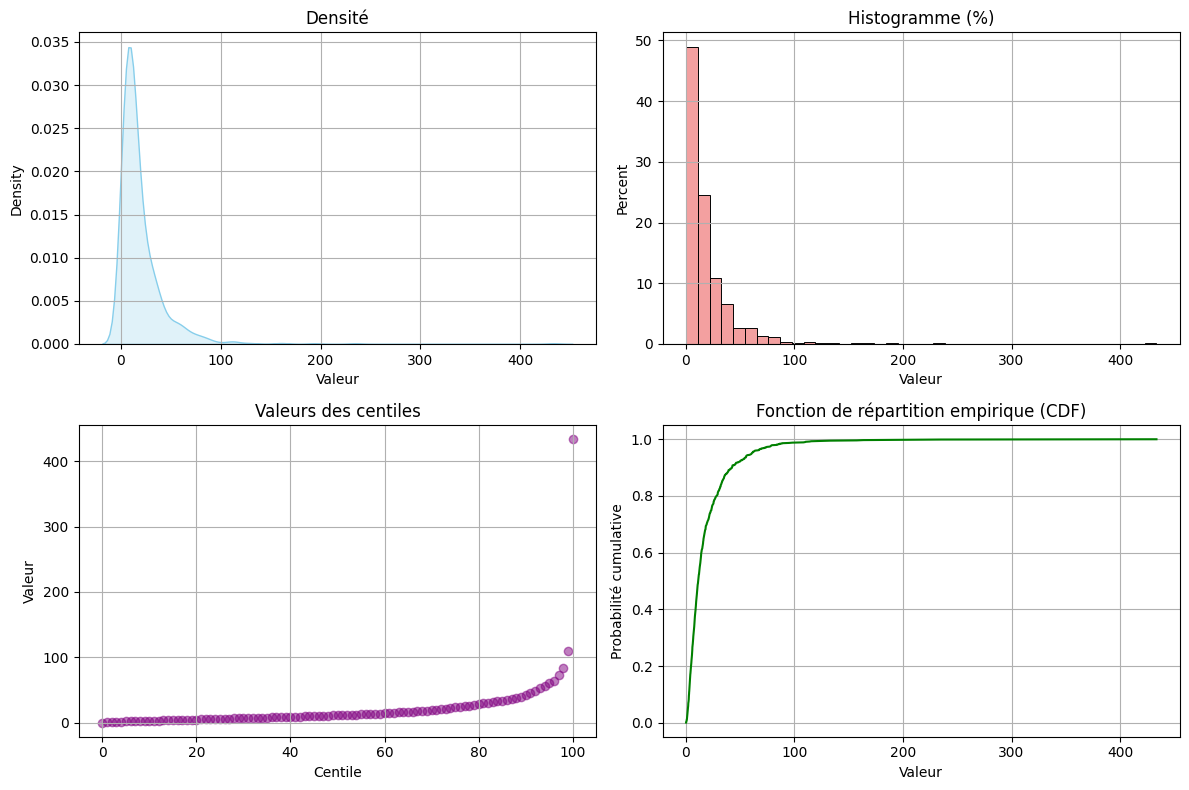

data
count  1000.000000
mean     19.239277
std      25.433106
min       0.481401
25%       6.143816
50%      11.690963
75%      23.780507
max     433.364519

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(123) 

data = np.random.lognormal(mean=2.5, sigma=1.0, size=1000)
sorted_data = np.sort(data)
cdf = np.arange(1, len(data) + 1) / len(data)

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])  # 2 lignes, 2 colonnes

# Graphique en haut à gauche
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data, fill=True, color='skyblue', ax=ax1)
ax1.set_title("Densité")
ax1.set_xlabel("Valeur")
ax1.grid(True)

# Graphique en haut à droite
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data, stat="percent", bins=40, color='lightcoral', ax=ax2)
ax2.set_title("Histogramme (%)")
ax2.set_xlabel("Valeur")
ax2.grid(True)

# Graphique en bas sur toute la largeur
ax3 = fig.add_subplot(gs[1, 0])

# Calcul des centiles (0 à 100)
centiles = np.arange(101)
valeurs = np.percentile(data, centiles)

ax3.scatter(centiles, valeurs, color="purple", alpha=0.5)
ax3.set_title("Valeurs des centiles")
ax3.set_xlabel("Centile")
ax3.set_ylabel("Valeur")
ax3.grid(True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(sorted_data, cdf, color="green")
ax4.set_title("Fonction de répartition empirique (CDF)")
ax4.set_xlabel("Valeur")
ax4.set_ylabel("Probabilité cumulative")
ax4.grid(True)

plt.tight_layout()
plt.show()

df = pd.DataFrame({"data": data})
df.describe()